In [1]:
import numpy as np
from IPython.display import clear_output
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from PIL import Image
from scipy.optimize import minimize
import f_class
from GP import GP
from GP_grad import GP_grad
from GD import GD
import time
import imageio
from torch.quasirandom import SobolEngine
import sobol_seq
from utils import *
import numdifftools as nd

#### Noiseless & Noisy

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and y, rememeber to scale the noise as well'''

'If use the scaled X and y, rememeber to scale the noise as well'

#### High-dimensional function $f$

In [3]:
objective = f_class.Hartmann_6(Noise, Noise_level)

# objective = f_class.Alpine(Noise, Noise_level) 
# objective = f_class.Ackley(Noise, Noise_level)
# objective = f_class.Michalewicz(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, dim=20)
# # objective = f_class.Rosenbrock(Noise, Noise_level)
# objective = f_class.Griewank(Noise, Noise_level)
# objective = f_class.Levy(Noise, Noise_level, dim=20)  
# objective = f_class.Rastrigin(Noise, Noise_level, dim=15)

f = objective.func
clean_f = lambda x: f_class.Hartmann_6().func(x)
# clean_f = lambda x: f_class.Alpine().func(x)
# clean_f = lambda x: f_class.Ackley().func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
# clean_f = lambda x: f_class.Schwefel(dim=20).func(x)
# clean_f = lambda x: f_class.Rosenbrock().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
# clean_f = lambda x: f_class.Levy(dim=20).func(x)
# clean_f = lambda x: f_class.Rastrigin(dim=15).func(x)
B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B) 
lb = B[:, 0]; ub = B[:, 1]


dim = objective.input_dim
print('dim: ', dim)
# print(f( np.array([dim*[1], dim*[1]])))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
dim:  6


#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [4]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))


def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [5]:
# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=2000)
# del gp
# (ls, var)

#### Sampling

In [6]:
def unique_row(X):
    """
    A functions to trim repeated rows that may appear when optimizing.
    :param X: array to trim repeated rows from
    :return: mask of unique rows
    """
    # Sort array and kep track of where things should go back to
    order = np.lexsort(X.T)
    reorder = np.argsort(order)

    X = X[order]
    diff = np.diff(X, axis=0)
    U = np.ones(len(X), 'bool')
    U[1:] = (diff != 0).any(axis=1)
    return U[reorder]

class close_data():
    def __init__(self, Xc, eps=1):
        self.Xc = Xc
        self.eps = eps
        
    # Iterable
    def __iter__(self):
        return self
    
    # Iterator
    def __next__(self):
        Xn = self.Xc + self.eps*np.random.uniform(-1, 1, self.Xc.shape)
        return Xn
    
def is_new(Xn, Xpast=None):
    if Xpast is None:
        return True
    else:
        return np.array([(i != Xn).any() for i in Xpast]).all()

def close_draw(Xc, n_random_draws=4, close=1, Xpast=None):
    # sample from a small 2d box with center given Xc, no repeated points
    X = np.zeros((n_random_draws, dim))
    X[0] = Xc
    counter = 0
    gc = close_data(Xc)
    while True:
        Xn = next(gc)
        if LA.norm(Xn - Xc) > 5e-2 and is_new(Xn, Xpast) == True:
            counter += 1
            X[counter] = Xn
        if counter == n_random_draws-1:
            break
    return X

### Grid

In [7]:
# n_Grid = dim
# G = np.zeros((dim, n_Grid))
# for i in range(dim):
#     G[i] = np.linspace(lb[i], ub[i], n_Grid)

# Grid = np.vstack( [axis.flatten() for axis in np.meshgrid(*(G[i] for i in range(G.shape[0])))] ).T
# Grid.shape

### Grid Approx Gradient

In [8]:
# # approximate the gradient
# from scipy import optimize

# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape

In [9]:
# # 3d plot of the gradient
# # approximate the gradient
# from scipy import optimize

# # optimize.approx_fprime(x, clean_Ackley_1d, eps)
# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape
# g1 = approx_grad[:, 0]
# g2 = approx_grad[:, 1]
# g1, g2

# BO

In [10]:
MAX = 150 # function observations

## Gradient-based Method

##### 1. Setup

In [11]:
# initial data
setup = 1
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))

# sample from a small 2d box
# Xc = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
# X = close_draw(Xc, n_random_draws=setup)

# X = np.vstack([X, np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))])

In [12]:
gp = GP_grad(B, Noise, Noise_level)
# gp.set_hyper(ls, var)  # if online, skip

gp.set_data(X, f(X))
ls, var = gp.optimize()
gp.set_hyper(ls, var)
gp.fit()

# w: starting point of GD
w = X[0].reshape(1, dim)
history = [(w, f(w))]

##### 2. Warm up

In [13]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
# warmup = 30
# history_warmup = []
# for i in range(1, warmup+1):
#     b = np.log(i)
#     w, fw = gp.ucb_minimize(b)
#     X = np.vstack([X, w])
    
#     print(i, end = ', ')
#     print('w: ', w, end = ', ')
#     print('f(w): ', f(w).item(), end = ', ')
#     print()
    
#     gp.add_data(w.reshape(1, dim), f(w))
    
#     if i % 5 == 0:
#         ls, var = gp.optimize()
#         print('  # Optimal (ls, var) = ', (ls, var))
#     gp.fit()
#     history.append( (w, f(w)) )
    
# X_fix = X

In [14]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
warmup = 5
for i in range(1, warmup+1):
    w = gp.Thompson_sample(n_mesh=gp.dim*100)
    gp.add_data(w.reshape(1, dim), f(w))
    if i % 5 == 0:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()    
                
    X = np.vstack([X, w])
    print(i, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    history.append( (w, f(w)) )
    
X_fix = X

1, w:  [0.66926789 0.00122128 0.9329505  0.70549136 0.26730543 0.14937721], f(w):  -0.01971357232079357, 
2, w:  [0.82623011 0.28475663 0.25858146 0.44276759 0.2774277  0.26899552], f(w):  -0.21815808225114355, 
3, w:  [0.65881574 0.17736851 0.86895198 0.21182549 0.30536723 0.04155051], f(w):  -0.05251474470090179, 
4, w:  [0.34877676 0.39692986 0.97924364 0.1847858  0.75356936 0.16567682], f(w):  -0.08706316355624173, 
  # Optimal (ls, var) =  (0.9038078606957731, 0.05)
5, w:  [0.28518897 0.6304099  0.76519364 0.0298347  0.81002557 0.58801818], f(w):  -0.20766147235478039, 


In [15]:
X_fix.shape

(6, 6)

##### 3. Optimize via GD

In [16]:
w = gp.X[np.argmin(gp.y)]
optimizer = GD(gp, B, w, f)

from scipy import optimize
eps = np.sqrt(np.finfo(float).eps)
gp.grad(w), gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

(array([[-0.01618025,  0.11098759,  0.12903192,  0.10061329,  0.03097042,
         -0.08404233]]),
 array([[ 0.4175928 ,  0.38134313,  0.10785976,  0.24405939, -0.20875758,
         -0.31694127]]),
 array([ 0.81411466,  0.17646616, -0.0708672 ,  0.65402182, -0.19915588,
        -1.33741965]))

In [17]:
gp.optimize()
np.set_printoptions(precision=4)
cost = setup + warmup
lr = 0.1
y_best = np.min(f(gp.X))

# create a candidate list of GD points from all queried points so far
optimizerHouse = [GD(gp, B, w, f) for w in gp.X]

In [18]:
ts_count = 0
print("starting best: ", y_best)
while cost <= MAX:
    print(cost, end = '. ')
    y_best = np.min(f(gp.X))
    delta = np.abs(1e-2 * y_best)
    maxPI = 0
    minEI = 0

    fullHistCandidates = []
    activeGDIndex = []
    
    # pick the potential GD -> min so far
    potentialOptimizer = sorted(filter(lambda x: x.Fail < x.stop, optimizerHouse), key=lambda x: x.minSofar)[:7]
    potentialOptimizerIndex = [optimizerHouse.index(opt) for opt in potentialOptimizer]

    for i in range(len(optimizerHouse)):
        if optimizerHouse[i].Fail < optimizerHouse[i].stop and i in potentialOptimizerIndex:
            w, fullHistRecord = optimizerHouse[i].no_update_sample(y_best=y_best, lr=lr)
            fullHistCandidates.append(fullHistRecord)
            activeGDIndex.append(i)

            # EI
            if gp.EI(w, optimizerHouse[i].minSofar - np.abs(1e-2 * optimizerHouse[i].minSofar)) < minEI:
                minEI = gp.EI(w, optimizerHouse[i].minSofar - np.abs(1e-2 * optimizerHouse[i].minSofar))
                bestW = w
                bestIndex = i
                 
              # PI
#             if gp.PI(w, y_best - delta) > maxPI:
#                 maxPI = gp.PI(w, y_best)
#                 bestW = w
#                 bestIndex = i
    
    if optimizerHouse[bestIndex].minSofar == y_best:
        maxPI = gp.PI(bestW, y_best)
    else:
        maxPI = gp.PI(bestW, optimizerHouse[bestIndex].minSofar - np.abs(1e-2 * optimizerHouse[bestIndex].minSofar))
    
    if np.random.uniform(0, 1, 1).item() < maxPI and cost > 20:
        print('GD Query with ', maxPI.item())
        print('    GD No, Loops, MinSofar = ', (bestIndex, len(optimizerHouse[bestIndex].history_full_w), optimizerHouse[bestIndex].minSofar.item() ))
        w = bestW
              
        # update that GD optimizer
        
        optimizerHouse[bestIndex].history_full_w = fullHistCandidates[activeGDIndex.index(bestIndex)]
        optimizerHouse[bestIndex].w = w
        optimizerHouse[bestIndex].history_w.append(w)

        if f(w) < optimizerHouse[bestIndex].minSofar:
            optimizerHouse[bestIndex].Fail = 0
            optimizerHouse[bestIndex].minSofar = f(w)
        else:
            optimizerHouse[bestIndex].Fail += 1
            
        if len(fullHistCandidates[activeGDIndex.index(bestIndex)]) > 49:
            optimizerHouse[bestIndex].stop = 0
              
#         print("Full GD path: ", np.vstack(optimizerHouse[bestIndex].history_full_w))

#     if np.abs(minEI) > delta:
#         print('GD suggests with EI, delta = ', np.abs(minEI), delta)
#         print('   GD (i, loop) ', (bestIndex, len(optimizerHouse[bestIndex].history_full_w) ))
#         w = bestW
    else:
        w = gp.Thompson_sample(n_mesh=2000)
        print('Thompson Query with Pr = ', 1 - maxPI)
#         print('UCB suggests with EI, delta ', np.abs(minEI), delta)
        ts_count += 1
        optimizerHouse.append(GD(gp, B, w, f))
        print('    Thompson No. ', ts_count)
        

    if is_new(w, gp.X) == False:
        print(w)
        print(gp.posterior_full_grad('full', dim*[w])[0])
        raise ValueError('  ? hit past points')
#         continue

    gp.add_data(w.reshape(1, -1), f(w))
    cost += 1
        
    # online hyper udpate + fitting GP with new query w
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    
    history.append( (w, f(w)) )
    m, v = gp.posterior_full_grad('full', dim*[w])
    v = np.sqrt(np.diag(v))
    print('    w: ', np.squeeze(w), end = ', ')
    print('    f(w): %.4f ' % f(w).item())
    print('    d(w): ', np.squeeze(m))
    print('    s.d: ', np.squeeze(v))
    print('    g(w):', optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps))
    print('    y best:', y_best)
    print()
        
print('Max Cost reached = ', cost)

starting best:  -0.21815808225114355
6. Thompson Query with Pr =  [0.1052]
    Thompson No.  1
    w:  [0.7728 0.0275 0.5224 0.9102 0.8932 0.4974],     f(w): -0.0009 
    d(w):  [ 0.0205 -0.002   0.0978  0.1833  0.1615 -0.0086]
    s.d:  [0.2313 0.1967 0.1936 0.2031 0.1685 0.2213]
    g(w): [ 0.011  -0.001  -0.0011  0.006   0.0014 -0.0013]
    y best: -0.21815808225114355

7. Thompson Query with Pr =  [0.1931]
    Thompson No.  2
    w:  [0.1324 0.8384 0.1983 0.0485 0.7214 0.1039],     f(w): -0.0555 
    d(w):  [-0.0626  0.1413 -0.098   0.0714  0.048  -0.1669]
    s.d:  [0.2025 0.2083 0.1801 0.2039 0.2245 0.1743]
    g(w): [-0.4622 -0.0119 -0.0574 -0.5291  0.0219  0.0469]
    y best: -0.21815808225114355

8. Thompson Query with Pr =  [0.1048]
    Thompson No.  3
  # Optimal (ls, var) =  (0.9573667097254827, 0.05)
    w:  [0.4051 0.9147 0.903  0.0361 0.2803 0.5444],     f(w): -0.1119 
    d(w):  [ 0.0116  0.1389  0.0807  0.0617 -0.1195 -0.1499]
    s.d:  [0.1998 0.1648 0.1602 0.1864 0.1

29. GD Query with  1.0
    GD No, Loops, MinSofar =  (11, 3, -1.5882821390604909)
  # Optimal (ls, var) =  (0.3031183747581516, 0.2815094457767566)
    w:  [0.0672 0.361  0.7381 0.2136 0.2494 0.7934],     f(w): -2.0692 
    d(w):  [-1.5634  0.2504  1.0718 -1.7287 -1.7814  0.4452]
    s.d:  [0.4389 0.7096 0.7949 0.3704 0.8319 0.354 ]
    g(w): [-1.668   1.8729  1.476  -1.9086 -1.923   0.8259]
    y best: -2.218291310431698

30. GD Query with  1.0
    GD No, Loops, MinSofar =  (20, 1, -1.5409093333086246)
    w:  [0.1072 0.3592 0.7095 0.2603 0.2652 0.7924],     f(w): -2.2655 
    d(w):  [-1.3374  0.4029  1.2741 -0.8177 -1.0595  0.9099]
    s.d:  [0.4474 0.8736 0.849  0.38   0.8532 0.4689]
    g(w): [-1.3753  2.2871  1.4202 -0.5886 -1.5628  1.7285]
    y best: -2.218291310431698

31. GD Query with  0.9999999997825901
    GD No, Loops, MinSofar =  (16, 3, -1.8692719886512383)
    w:  [0.1198 0.3949 0.701  0.293  0.3119 0.8293],     f(w): -2.1190 
    d(w):  [-0.7709  2.404   1.5716  0.7297

  # Optimal (ls, var) =  (0.2941761012791446, 0.48839930658581004)
    w:  [0.2134 0.1438 0.4733 0.265  0.3047 0.6729],     f(w): -3.3082 
    d(w):  [ 0.7691 -0.6379  0.0872 -0.2052 -0.5215  0.5995]
    s.d:  [0.3126 0.3216 0.3937 0.2936 0.2838 0.2457]
    g(w): [ 0.2725 -0.1443 -0.0504 -0.6594 -0.6651  0.8018]
    y best: -3.2744815692245663

51. GD Query with  0.296712566073195
    GD No, Loops, MinSofar =  (11, 8, -3.24332704481884)
    w:  [0.1431 0.1214 0.4276 0.2585 0.3016 0.6848],     f(w): -3.2121 
    d(w):  [-1.6792 -0.8194 -0.9083 -0.6722 -1.3091  1.5728]
    s.d:  [0.3935 0.5376 0.4795 0.5355 0.618  0.5901]
    g(w): [-1.4886 -0.6085 -0.8866 -1.1005 -0.909   1.3917]
    y best: -3.3082222695613073

52. GD Query with  0.8983108809548602
    GD No, Loops, MinSofar =  (18, 6, -3.1617880274550467)
    w:  [0.1602 0.1352 0.4517 0.2537 0.3568 0.6672],     f(w): -3.1780 
    d(w):  [-1.5418 -0.5363 -0.1734 -1.51    3.6139 -0.1696]
    s.d:  [0.2857 0.377  0.3932 0.4171 0.2577 0.5

72. Thompson Query with Pr =  [1.]
    Thompson No.  28
    w:  [0.5265 0.1607 0.5455 0.4995 0.2783 0.8768],     f(w): -1.0906 
    d(w):  [ 1.7745 -0.0928  0.4113  3.6222 -0.9918  3.5327]
    s.d:  [1.561  1.8802 1.7848 1.7375 1.9142 1.7992]
    g(w): [ 1.9101 -0.3995 -0.3421  4.1661 -0.6324  3.0521]
    y best: -3.3137318351847926

73. Thompson Query with Pr =  [1.]
    Thompson No.  29
    w:  [0.3144 0.1955 0.6387 0.3097 0.3648 0.5847],     f(w): -2.6011 
    d(w):  [ 2.6804  0.9785  3.2473  1.6902  4.2308 -2.9393]
    s.d:  [0.5991 0.5925 0.4635 0.7309 0.7525 0.6867]
    g(w): [ 2.2646  0.7512  2.9646  1.6389  4.1891 -3.1509]
    y best: -3.3137318351847926

74. Thompson Query with Pr =  [1.]
    Thompson No.  30
  # Optimal (ls, var) =  (0.3004373199008032, 0.4726269255271585)
    w:  [0.2506 0.3796 0.4492 0.2748 0.2903 0.6336],     f(w): -2.7087 
    d(w):  [ 1.0714  4.2944 -0.5568 -0.0055 -1.6106 -1.0291]
    s.d:  [0.5245 0.3151 0.4168 0.3748 0.5062 0.4471]
    g(w): [ 0.9283 

95. Thompson Query with Pr =  [1.]
    Thompson No.  51
  # Optimal (ls, var) =  (0.3097859610483702, 0.44476207547065194)
    w:  [0.2165 0.2881 0.4161 0.3208 0.3734 0.6442],     f(w): -2.8403 
    d(w):  [ 0.2503  2.6966 -1.0138  2.3799  5.3949 -0.4958]
    s.d:  [0.2204 0.1527 0.1309 0.2093 0.1781 0.2022]
    g(w): [ 0.2545  2.7306 -1.0241  2.3116  5.427  -0.6053]
    y best: -3.3137318351847926

96. Thompson Query with Pr =  [1.]
    Thompson No.  52
    w:  [0.3224 0.2422 0.3318 0.3999 0.3746 0.6777],     f(w): -2.4150 
    d(w):  [ 1.6808  1.684  -0.9283  5.3402  5.4242  0.2958]
    s.d:  [0.3871 0.4299 0.3956 0.3431 0.4996 0.4993]
    g(w): [ 1.6391  1.6043 -1.0518  5.4412  5.297   0.6166]
    y best: -3.3137318351847926

97. Thompson Query with Pr =  [1.]
    Thompson No.  53
    w:  [0.16   0.0078 0.5399 0.355  0.3205 0.6124],     f(w): -2.8163 
    d(w):  [-1.1349 -2.904   1.2168  4.0244  0.3849 -1.8484]
    s.d:  [0.4973 0.2996 0.4068 0.4499 0.5333 0.4417]
    g(w): [-0.8633

118. Thompson Query with Pr =  [1.]
    Thompson No.  73
    w:  [0.1417 0.3028 0.3236 0.2656 0.2624 0.6422],     f(w): -2.7435 
    d(w):  [-1.5973  3.0869 -1.6733 -0.7901 -3.4606 -0.8772]
    s.d:  [0.2611 0.2155 0.151  0.203  0.3454 0.3157]
    g(w): [-1.4022  2.9693 -1.6307 -0.8694 -4.0202 -0.8068]
    y best: -3.3137318351847926

119. Thompson Query with Pr =  [1.]
    Thompson No.  74
  # Optimal (ls, var) =  (0.31603766058743615, 0.4270087552010756)
    w:  [0.1946 0.1742 0.5526 0.3458 0.3033 0.6899],     f(w): -3.0858 
    d(w):  [-0.2146  0.4337  1.4629  3.9422 -0.7021  1.4328]
    s.d:  [0.0943 0.0718 0.0625 0.0764 0.1303 0.1133]
    g(w): [-0.1713  0.3919  1.4435  3.9548 -0.6831  1.3806]
    y best: -3.3137318351847926

120. Thompson Query with Pr =  [1.]
    Thompson No.  75
    w:  [0.2761 0.2801 0.3812 0.2985 0.2322 0.6626],     f(w): -2.7420 
    d(w):  [ 1.134   2.5108 -0.9681  0.9056 -6.5029 -0.0066]
    s.d:  [0.2036 0.1652 0.1846 0.2237 0.2164 0.2196]
    g(w): [ 1.1

141. Thompson Query with Pr =  [1.]
    Thompson No.  96
    w:  [0.3046 0.1972 0.5704 0.4114 0.318  0.8004],     f(w): -2.2814 
    d(w):  [1.2821 0.5828 0.9802 5.6183 0.5501 4.5915]
    s.d:  [0.242  0.3184 0.3085 0.3477 0.4146 0.2827]
    g(w): [1.4935 0.3554 0.7421 5.4496 0.9034 4.4498]
    y best: -3.3137318351847926

142. Thompson Query with Pr =  [1.]
    Thompson No.  97
    w:  [0.0342 0.0809 0.4053 0.3193 0.3764 0.6187],     f(w): -2.6312 
    d(w):  [-3.4885 -1.3427 -1.1577  2.1657  5.1177 -1.5624]
    s.d:  [0.1983 0.2493 0.2211 0.2489 0.2712 0.2668]
    g(w): [-3.3893 -1.2166 -1.1634  2.096   5.2151 -1.5899]
    y best: -3.3137318351847926

143. Thompson Query with Pr =  [1.]
    Thompson No.  98
  # Optimal (ls, var) =  (0.3170779715772117, 0.38339947036753713)
    w:  [0.4566 0.1672 0.3362 0.2535 0.2589 0.5391],     f(w): -2.2397 
    d(w):  [ 3.2988  0.4125 -0.3722 -1.373  -3.0684 -4.2307]
    s.d:  [0.3269 0.4008 0.3981 0.5145 0.5959 0.4549]
    g(w): [ 3.3417  0.3261 

In [19]:
optimizerHouse[11].stop 

4

<ipython-input-20-d537c60e90a8>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history)[:, 1]), "-^", lw=0.5)
<ipython-input-20-d537c60e90a8>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=3)


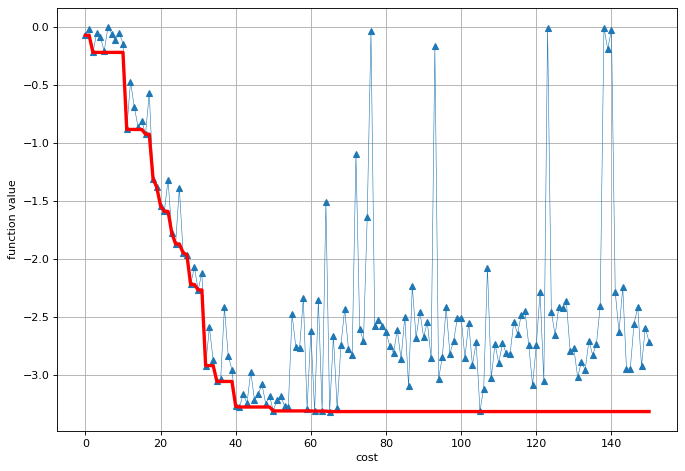

In [20]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.squeeze(np.array(history)[:, 1]), "-^", lw=0.5)
pl.xlabel("cost")
pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=3)
pl.ylabel("function value")
pl.grid(True)

## Minima of GD

In [21]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([0.1994, 0.1287, 0.4944, 0.2766, 0.312 , 0.6555]),
 -3.3137318351847926,
 65)

In [22]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### *Thompson Sampling, UCB*

In [23]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
# X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history_ucb = []
for a in X_fix:
    history_ucb.append( (a, f(a)) )

In [24]:
cost = setup + warmup
while cost < MAX:
    # 1. Thompson Sampling
    w = gp.Thompson_sample(n_mesh=2000)
    # 2. GP_UCB
#     b = np.log(cost**gp.dim)
#     arg_min = np.argmin(mu.reshape(-1,1) - np.sqrt(b)*s.reshape(-1, 1)) # discrete version
#     w = Grid[arg_min]
#     w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    

#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = '. ')
    print('w: ', w)
    print('  f(w): ', f(w).item())
    print('  y_best: ', np.min(f(gp.X)))
    print()
    
    history_ucb.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

6. w:  [0.9867 0.9548 0.092  0.0284 0.2386 0.6955]
  f(w):  -0.02318455274268507
  y_best:  -0.21815808225114355

  # Optimal (ls, var) =  (0.9057990647910468, 0.05)
7. w:  [0.002  0.7032 0.5543 0.375  0.9733 0.9713]
  f(w):  -0.0684527899587273
  y_best:  -0.21815808225114355

8. w:  [0.0347 0.9133 0.9655 0.1937 0.1317 0.6761]
  f(w):  -0.11831405941089813
  y_best:  -0.21815808225114355

9. w:  [0.9399 0.3046 0.0068 0.3047 0.0919 0.0862]
  f(w):  -0.01672846296924599
  y_best:  -0.21815808225114355

  # Optimal (ls, var) =  (0.6716515695788445, 0.05)
10. w:  [0.8452 0.0034 0.1605 0.1269 0.554  0.7144]
  f(w):  -0.2259980474034632
  y_best:  -0.21815808225114355

11. w:  [0.6566 0.3722 0.4242 0.8871 0.2173 0.9953]
  f(w):  -0.07671808083565723
  y_best:  -0.2259980474034632

12. w:  [0.0058 0.7995 0.1156 0.1513 0.8762 0.152 ]
  f(w):  -0.027951244539669188
  y_best:  -0.2259980474034632

  # Optimal (ls, var) =  (0.7081100488197012, 0.05)
13. w:  [0.969  0.0099 0.0412 0.8796 0.2543 0.

69. w:  [0.2276 0.3273 0.3786 0.3042 0.3479 0.6655]
  f(w):  -2.817696516469663
  y_best:  -2.9150840017380855

  # Optimal (ls, var) =  (0.27942423138479733, 0.2995682878995313)
70. w:  [0.2726 0.1384 0.6053 0.0798 0.2914 0.5487]
  f(w):  -2.028761747346454
  y_best:  -2.9150840017380855

71. w:  [0.2541 0.1349 0.3762 0.3935 0.2676 0.5843]
  f(w):  -2.659359692048594
  y_best:  -2.9150840017380855

72. w:  [0.2722 0.1249 0.3967 0.2846 0.2243 0.6537]
  f(w):  -2.8757422689312526
  y_best:  -2.9150840017380855

  # Optimal (ls, var) =  (0.2786114965167859, 0.3116058000785774)
73. w:  [0.1831 0.1955 0.5883 0.1314 0.3131 0.7011]
  f(w):  -2.6511795524639545
  y_best:  -2.9150840017380855

74. w:  [0.3262 0.0371 0.5689 0.298  0.236  0.7013]
  f(w):  -2.6309195054315557
  y_best:  -2.9150840017380855

75. w:  [0.1735 0.1744 0.4553 0.1877 0.1956 0.6926]
  f(w):  -2.490341670090731
  y_best:  -2.9150840017380855

  # Optimal (ls, var) =  (0.2797718531122713, 0.3069198552184766)
76. w:  [0.268

131. w:  [0.2219 0.1671 0.4243 0.3113 0.3768 0.6102]
  f(w):  -2.9923953538833112
  y_best:  -3.1409550251032368

132. w:  [0.1904 0.0327 0.6039 0.3186 0.2348 0.611 ]
  f(w):  -2.6408803112405157
  y_best:  -3.1409550251032368

  # Optimal (ls, var) =  (0.3077538593742904, 0.3256539312298692)
133. w:  [0.1723 0.079  0.4864 0.1756 0.4072 0.6511]
  f(w):  -2.663242389035933
  y_best:  -3.1409550251032368

134. w:  [0.2791 0.0327 0.3527 0.1931 0.3228 0.6154]
  f(w):  -2.7562374508263754
  y_best:  -3.1409550251032368

135. w:  [0.1745 0.1432 0.5562 0.2947 0.2303 0.804 ]
  f(w):  -2.515769209273493
  y_best:  -3.1409550251032368

  # Optimal (ls, var) =  (0.30890903175532175, 0.325123986998632)
136. w:  [0.0982 0.1734 0.4707 0.3121 0.24   0.5976]
  f(w):  -2.8266562577232324
  y_best:  -3.1409550251032368

137. w:  [0.3384 0.2768 0.2225 0.2044 0.3268 0.6915]
  f(w):  -2.4917412306228752
  y_best:  -3.1409550251032368

138. w:  [0.3021 0.0314 0.6414 0.2684 0.2546 0.5616]
  f(w):  -2.4405135

<ipython-input-25-3916f7118cdf>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history_ucb)[:, 1]), "-^", lw=0.5)
<ipython-input-25-3916f7118cdf>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history_ucb)[:, 1]), 'r', lw=2)


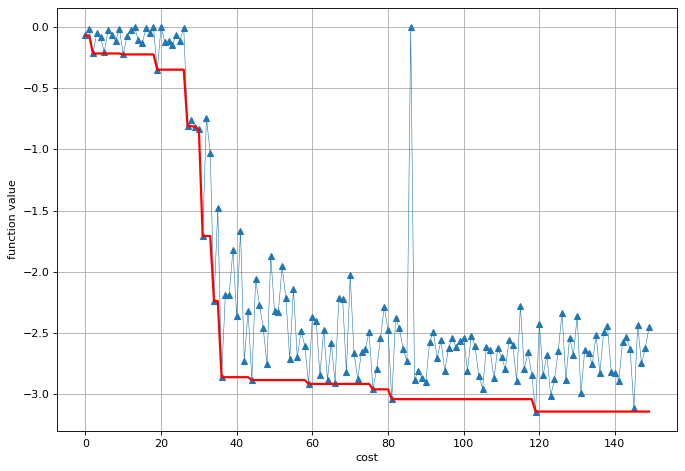

In [25]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.squeeze(np.array(history_ucb)[:, 1]), "-^", lw=0.5)
pl.plot(np.minimum.accumulate(np.array(history_ucb)[:, 1]), 'r', lw=2)
pl.xlabel("cost")
pl.ylabel("function value")
pl.grid(True)

## Global Minima 

In [26]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([0.2613, 0.0951, 0.5129, 0.3236, 0.2897, 0.6575]),
 -3.1409550251032368,
 119)

In [27]:
gp.get_hyper()

{'var': 0.326013596298584, 'lengthscale': 0.3137158589718244}

<ipython-input-28-815289da398e>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history_ucb)[:, 1]), 'r', lw=3, label='Thompson')
<ipython-input-28-815289da398e>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'b', lw=3, label='GD')


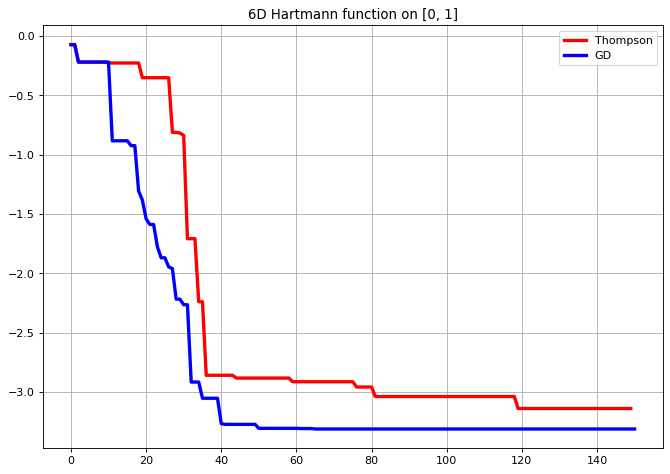

In [28]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.minimum.accumulate(np.array(history_ucb)[:, 1]), 'r', lw=3, label='Thompson')
# pl.plot(np.minimum.accumulate(np.array(history_EI)[:, 1]), 'b', lw=2, label='EI')
pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'b', lw=3, label='GD')
pl.title("6D Hartmann function on [0, 1]")
pl.legend()
pl.grid(True)